## Import packages

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read data

Read the file **sou_rec_pos.pkl** with pandas as DataFrame and the file **seismic_data_source_1000.nc** with xarray as DataSet

In [2]:
sou_rec_pos = pd.read_pickle("sou_rec_pos.pkl")
seismic_data= xr.open_dataset("seismic_data_source_1000.nc")
seismic_data

<xarray.Dataset>
Dimensions:  (twt: 4001, time: 4001, cdp: 1180)
Coordinates:
  * twt      (twt) float64 0.0 2.0 4.0 6.0 ... 7.996e+03 7.998e+03 8e+03
  * time     (time) float32 0.0 0.002 0.004 0.006 ... 7.994 7.996 7.998 8.0
  * cdp      (cdp) int32 871637 871638 871639 871640 ... 872814 872815 872816
Data variables:
    data     (cdp, time) float32 ...
Attributes: (12/13)
    ns:                  None
    sample_rate:         2.0
    text:                C 1 CLIENT                        COMPANY           ...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         Niscota_4B.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-8.89837605e+02 -8.00424402e+02 -1.07494686e+02  1....
    coord_scalar:        1.0

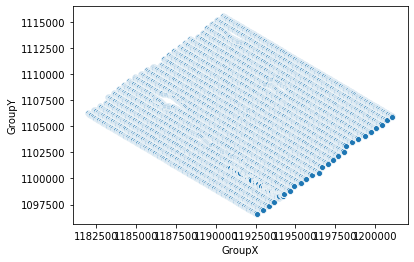

,EnergySourcePoint,SourceX,SourceY,GroupX,GroupY
0,1,1182365,1105911,1181982,1106233
1,1,1182365,1105911,1182018,1106201
2,1,1182365,1105911,1182053,1106169
3,1,1182365,1105911,1182089,1106137
4,1,1182365,1105911,1182124,1106105
...,...,...,...,...,...
2981934,2933,1198355,1107376,1200942,1106056
2981935,2933,1198355,1107376,1200978,1106024
2981936,2933,1198355,1107376,1201013,1105992
2983819,2935,1198191,1106850,1201049,1105959


In [5]:
rec_pos=sou_rec_pos.drop_duplicates(subset=['GroupX','GroupY'])
sns.scatterplot(data=rec_pos, x="GroupX", y="GroupY")
plt.show()
rec_pos

## Create new dimensions
Compute **Azimuth** and **Offset** from sources and receivers positions.

In [ ]:
pos_x=np.array(sou_rec_pos['SourceX']-sou_rec_pos['GroupX'], dtype='f')
pos_y=np.array(sou_rec_pos['SourceY']-sou_rec_pos['GroupY'], dtype='f')
azimuth=np.arctan2(-pos_x, pos_y) * 180 / np.pi+180
offset = np.linalg.norm([pos_x,pos_y], axis=0)  
sou_rec_pos['Azimuth']=azimuth
sou_rec_pos['Offset']=offset
sou_rec_pos

Histogram of the **Azimuth** for the source 1000.

In [ ]:
source=1000
shot_pos=sou_rec_pos[sou_rec_pos['EnergySourcePoint']==source]
shot_pos[['Azimuth']].plot.hist()
plt.show()

## Highligth position by azimuth bin
Show receivers fro the source 1000 with azimuth from 90 to 110.

In [ ]:
az_1=90 
az_2=110                  #Limit values of azimuth
shot_azimuth_pos=shot_pos[(shot_pos['Azimuth']>az_1)&(shot_pos['Azimuth']<az_2)]
sns.scatterplot(data=sou_rec_pos, x="GroupX", y="GroupY")
sns.scatterplot(data=shot_azimuth_pos, x="GroupX", y="GroupY")
sns.scatterplot(data=shot_azimuth_pos, x="SourceX", y="SourceY")
plt.show()

## Selecting traces for the azimuth bin
Create the azimuth coordinate for the DataSet **seismic_data**

In [ ]:
seismic_data["azimuth"] = ("azimuth",  shot_pos['Azimuth'])
seismic_data["offset"] = ("azimuth",  shot_pos['Offset'])
seismic_data["data"] = (("azimuth", "time"), np.array(seismic_data.data))
seismic_data

Select DataArray **data_azimuth** from the DataSet **seimisc_data** in the azimuth bin.

In [ ]:
data = seismic_data.where((seismic_data.azimuth>az_1)&(seismic_data.azimuth<az_2), drop=True)  #Select traces for the azimuth bin
data_azimuth = data.data.sortby('azimuth') #Sort DataArray by azimuth
data_azimuth

Plot the shot gather foe the azimuth bin sort by azimuth.

In [ ]:
data_azimuth.plot.imshow('azimuth','time',cmap='gray', vmin=-1000, vmax=1000, origin='upper')

## Sort the data by offset
Select DataArray **data_offset** from the DataSet **data** in the azimuth bin.

In [ ]:
data=data.swap_dims({"azimuth": "offset"})
data_offset = data.data.sortby('offset') #Sort DataArray by offset
data_offset

In [ ]:
data_offset.plot.imshow('offset','time',cmap='gray', vmin=-1000, vmax=1000, origin='upper')

Plot the shot gather for the azimuth bin sort by offset.

In [ ]:
import masw_functions as mf
vmin=100.0 
vmax=4001.0
fmin=1.0 
fmax=8.0
pstep=5e-5
Nf=4001
v=np.arange(vmin,vmax)
D=mf.DispersionSpectrum(data_offset,v,fmin,fmax,Nf,pstep)
plt.rcParams['figure.figsize'] = [12, 6]
D.plot.imshow(D.dims[1],D.dims[0],cmap='viridis', origin='lower')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase velocity (m/s)")

In [ ]:
Xobs=mf.AutomaticPicking(D,threshold=0.8,num=30,fig=True)

In [ ]:
Nh=10
(vsia,hia,zia)=mf.InitialModel(Xobs,Nh)
plt.rcParams['figure.figsize'] = [6, 6]
plt.figure()
plt.step(np.append(vsia,vsia[-1]),zia,label='Initial model',color='blue')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("S-wave velocity (m/s)")
plt.ylabel("Depth (m)")

In [ ]:
rps=2.5
alpha=Nh*10
n_iter=20
rhoia=2*np.ones(np.size(vsia))
dh=1.0
#(vsfa,vpfa,e)=mf.sw_inversion(Xobs[:,1],Xobs[:,0],vsia,rhoia,hia,rps,n_iter,alpha,dh)

plt.rcParams['figure.figsize'] = [15, 6]
fig, axs = plt.subplots(1,2)
axs[0].step(np.append(vsia,vsia[-1]),zia, color='blue', label='Initial')
axs[0].step(np.append(vsfa,vsfa[-1]),zia, color='green', label='Inversion')
axs[0].set(xlabel='S-wave velocity (m/s)', ylabel='Depth (m)')
axs[0].legend()
axs[0].invert_yaxis()

cRia=mf.forward_dispersion(vsia,rps*vsia,rhoia,hia,Xobs[:,0])
cRfa=mf.forward_dispersion(vsfa,rps*vsfa,rhoia,hia,Xobs[:,0])
axs[1].plot(Xobs[:,0], Xobs[:,1], 'o--', color='black', label='Observed')
axs[1].plot(Xobs[:,0], cRia, 'o--', color='blue', label='Initial')
axs[1].plot(Xobs[:,0], cRfa, 'o--', color='green', label='Inversion')
axs[1].set(xlabel='Frequency (Hz)', ylabel='Phase velocity (m/s)')
axs[1].legend()